In [1]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kusmo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [4]:
stop_words = set(stopwords.words("indonesian")) 
def bersihkan_teks(teks):
    teks = teks.lower()
    teks = re.sub(r'\d+', '', teks)
    teks = re.sub(r"http\S+|www\S+|https\S+", "", teks, flags=re.MULTILINE)
    teks = re.sub(r"@\w+|#", "", teks)
    teks = re.sub(r"[^\w\s]", "", teks)
    teks = re.sub(r'<.*?>', '', teks)
    teks = re.sub(r'\s+', ' ', teks).strip()
    teks = " ".join([stemmer.stem(word) for word in teks.split() if word not in stop_words])
    return teks

In [5]:
df = pd.read_csv("dataset_pengaduan.csv")

In [6]:
df['konten'] = df['pengaduan'].apply(bersihkan_teks)
df['pengaduan'] = df['konten']
df.drop(columns=['pengaduan'], inplace=True)

In [7]:
df_classification = df[['date','konten', 'kategori', 'sentimen']]
df_classification.head()

,date,konten,kategori,sentimen
0,1980-01-01,macet parah area parkir pintu masuk,Transportasi,negatif
1,1980-01-02,kualitas ajar turun pustaka pustaka guru profe...,Pendidikan,positif
2,1980-01-03,fasilitas sekolah manajemen buruk minim ruang ...,Pendidikan,negatif
3,1980-01-04,sedia obat darurat cukup menit pasien,Kesehatan,positif
4,1980-01-05,jadwal bus menit lambat tumpang pagi,Transportasi,netral


# Pre-proccessing Data

## pre-sklearn

Ekstrasi fitur menggunakan TF-IDF untuk menghitung nilai dari kata.

In [8]:
tfidf = TfidfVectorizer()
konten_tfidf = tfidf.fit_transform(df_classification['konten']).toarray()

Mengubah kategori menjadi label agar bisa digabung untuk meningkatkan kualitas training.

In [9]:
ohe = OneHotEncoder()
kategori_encoded = ohe.fit_transform(df_classification[['kategori']]).toarray()

Mengubah sentimen menjadi label, agar bisa digunakan untuk prediksi

In [10]:
le = LabelEncoder()

## pre-deep learning

In [11]:
df_classification['date'] = pd.to_datetime(df_classification['date'])

df_classification['year'] = df_classification['date'].dt.year
df_classification['month'] = df_classification['date'].dt.month
df_classification['day'] = df_classification['date'].dt.day
df_classification['weekday'] = df_classification['date'].dt.weekday

C:\Users\kusmo\AppData\Local\Temp\ipykernel_11416\2359209205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classification['date'] = pd.to_datetime(df_classification['date'])
C:\Users\kusmo\AppData\Local\Temp\ipykernel_11416\2359209205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classification['year'] = df_classification['date'].dt.year


In [12]:
date_features = df_classification[['year', 'month', 'day', 'weekday']].values

In [13]:
scaler = MinMaxScaler()
date_features_scaled = scaler.fit_transform(date_features)

# Split data

## Split for sklearn

In [14]:
feature = np.hstack((konten_tfidf, kategori_encoded, date_features_scaled))
target = le.fit_transform(df_classification['sentimen'])

In [15]:
X = feature
y = target

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42)

## Split for Deep Learning

### Ekstraksi Fitur khusus deep learning

In [17]:
df_train, df_val = train_test_split(df_classification, test_size=0.2, random_state=42)

In [18]:
tfidf = TfidfVectorizer()
konten_train = tfidf.fit_transform(df_train['konten']).toarray()
konten_val = tfidf.transform(df_val['konten']).toarray()

ohe = OneHotEncoder()
kategori_train = ohe.fit_transform(df_train[['kategori']]).toarray()
kategori_val = ohe.transform(df_val[['kategori']]).toarray()

for df in [df_train, df_val]:
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday

date_features_train = df_train[['year', 'month', 'day', 'weekday']].values
date_features_val = df_val[['year', 'month', 'day', 'weekday']].values

scaler = MinMaxScaler()
date_features_train_scaled = scaler.fit_transform(date_features_train)
date_features_val_scaled = scaler.transform(date_features_val)

In [19]:
X_train_nn = np.hstack((konten_train, kategori_train, date_features_train_scaled))
X_val = np.hstack((konten_val, kategori_val, date_features_val_scaled))

In [20]:
le = LabelEncoder()
y_train_nn = le.fit_transform(df_train['sentimen'])
y_val = le.transform(df_val['sentimen'])

### Split Data

In [21]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [22]:
train_dataset = CustomDataset(X_train_nn, y_train_nn)
val_dataset = CustomDataset(X_val, y_val)

In [23]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Pembuatan Model

## Model sklearn

In [24]:
model_xgb = XGBClassifier()
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)

## Model Deep Learning menggunakan Pytorch

In [25]:
class DL_model(nn.Module):
    def __init__(self, input_dim, hidden_dims=[1024, 512, 256, 128, 64], num_classes=3):
        super(DL_model, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.BatchNorm1d(dim),
                nn.Dropout(0.5)
            ])
            prev_dim = dim
            
        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

Balancing sentiment

In [26]:
print(df_classification['sentimen'].value_counts()) 

sentimen
negatif    9850
positif    5978
netral     4172
Name: count, dtype: int64


In [27]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),  
    y=y_train 
)
class_weight_dict = dict(enumerate(class_weights))

In [28]:
# for key in class_weight_dict:
#     class_weight_dict[key] = min(class_weight_dict[key], 1.5)

In [29]:
print(class_weight_dict)

{0: 0.6753619517960406, 1: 1.6049754238138227, 2: 1.1157601115760112}


# Training Model

## Model sklearn

In [30]:
#Training Model XGBoost
model_xgb.fit(X_train, y_train)
y_train_predic_xgb = model_xgb.predict(X_train)
y_test_predic_xgb = model_xgb.predict(X_test)

In [31]:
train_accuracy_xgb = accuracy_score(y_train, y_train_predic_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_predic_xgb)

print("XGBoost:")
print(f"Akurasi Training: {train_accuracy_xgb:.4f}")
print(f"Akurasi Testing: {test_accuracy_xgb:.4f}")

XGBoost:
Akurasi Training: 0.6339
Akurasi Testing: 0.4690


In [32]:
#Training Model Random Forest
model_rf.fit(X_train, y_train)
y_train_predic_rf = model_rf.predict(X_train)
y_test_predic_rf = model_rf.predict(X_test)

In [33]:
train_accuracy_rf = accuracy_score(y_train, y_train_predic_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_predic_rf)

print("Random Forest:")
print(f"Akurasi Training: {train_accuracy_rf:.4f}")
print(f"Akurasi Testing: {test_accuracy_rf:.4f}")

Random Forest:
Akurasi Training: 1.0000
Akurasi Testing: 0.4223


## Model Pytorch

In [34]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        self.verbose = verbose
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy() 
            if self.verbose:
                print(f'Validation loss: {val_loss:.6f} (first checkpoint). Saving model...')
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience} (best: {self.best_loss:.6f}, current: {val_loss:.6f})')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0

In [35]:
input_dim = X_train.shape[1]
deep_model = DL_model(input_dim=input_dim)

In [36]:
accelerator = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deep_model = deep_model.to(accelerator)

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(deep_model.parameters(), lr=0.005, weight_decay=1e-4)

In [38]:
class_weights= torch.FloatTensor(class_weights).to(accelerator)

train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [39]:
def training(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    early_stopping = EarlyStopping(patience=5, verbose=True)
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(accelerator), labels.to(accelerator)
            
            #forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            #backward and optim
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accelerator
            
            #statistic
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        model.eval()  
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():  
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(accelerator), val_labels.to(accelerator)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                val_running_loss += val_loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()
        
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = 100 * val_correct / val_total
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_acc:.2f}%')
    
        early_stopping(val_epoch_acc, model)
        if early_stopping.early_stop:   
            print("There is no improvement, Early Stopping Activated!")
            model.load_state_dict(early_stopping.best_model)
            break
        
        
    return train_losses, train_accs, val_losses, val_accs

In [40]:
train_losses, train_accur, val_loss, val_acc = training(
    deep_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=100
)

Epoch [1/100], Train Loss: 1.0734, Train Accuracy: 45.79%, Val Loss: 1.0473, Val Accuracy: 48.83%
Validation loss: 48.825000 (first checkpoint). Saving model...
Epoch [2/100], Train Loss: 1.0491, Train Accuracy: 48.59%, Val Loss: 1.0446, Val Accuracy: 48.75%
Epoch [3/100], Train Loss: 1.0441, Train Accuracy: 48.86%, Val Loss: 1.0419, Val Accuracy: 48.83%
EarlyStopping counter: 1/5 (best: 48.750000, current: 48.825000)
Epoch [4/100], Train Loss: 1.0414, Train Accuracy: 49.21%, Val Loss: 1.0410, Val Accuracy: 48.83%
EarlyStopping counter: 2/5 (best: 48.750000, current: 48.825000)
Epoch [5/100], Train Loss: 1.0401, Train Accuracy: 49.27%, Val Loss: 1.0416, Val Accuracy: 48.83%
EarlyStopping counter: 3/5 (best: 48.750000, current: 48.825000)
Epoch [6/100], Train Loss: 1.0384, Train Accuracy: 49.34%, Val Loss: 1.0406, Val Accuracy: 48.83%
EarlyStopping counter: 4/5 (best: 48.750000, current: 48.825000)
Epoch [7/100], Train Loss: 1.0378, Train Accuracy: 49.35%, Val Loss: 1.0409, Val Accuracy

In [41]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test = torch.FloatTensor(X_test).to(accelerator)
        y_test = torch.LongTensor(y_test).to(accelerator)
        
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)
        
        accuracy = (predicted == y_test).sum().item() / len(y_test)
        
    return accuracy

In [42]:
test_accuracy = evaluate_model(deep_model, X_test, y_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Test Accuracy: 48.83%


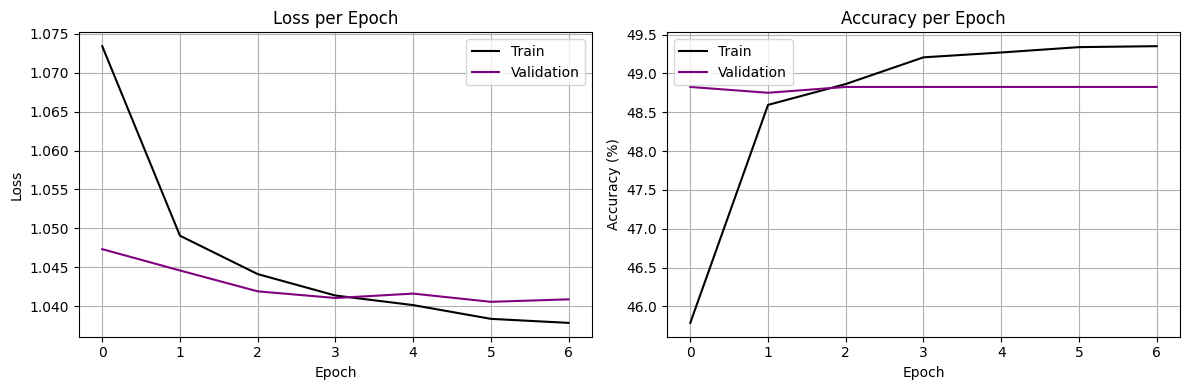

In [53]:
def plot_training_history(train_losses, train_accs, val_loss, val_acc):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)  
    plt.plot(train_losses, label='Train', color='black')
    plt.plot(val_loss, label='Validation', color='purple')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Grafik untuk Akurasi
    plt.subplot(1, 2, 2)  
    plt.plot(train_accs, label='Train', color='black')
    plt.plot(val_acc, label='Validation', color='purple')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()  
    plt.grid()

    plt.tight_layout()  
    plt.show()
    
plot_training_history(train_losses, train_accur, val_loss, val_acc)